In [1]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
rgb = plt.imread('./captured_images/rgb.png')[:, :, :3]
depth = np.load('./captured_images/depth.npy')
depth_img = np.repeat(depth[:, :, np.newaxis], 3, axis=2)

seg = np.load('./captured_images/segmentation.npy')
proj_matrix = np.load('./captured_images/projection_matrix.npy')
view_matrix = np.load('./captured_images/view_matrix.npy')
view_inv = np.linalg.inv(view_matrix)

depth[depth < -2] = 0
# depth = depth * -1

/home/faizal/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/faizal/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


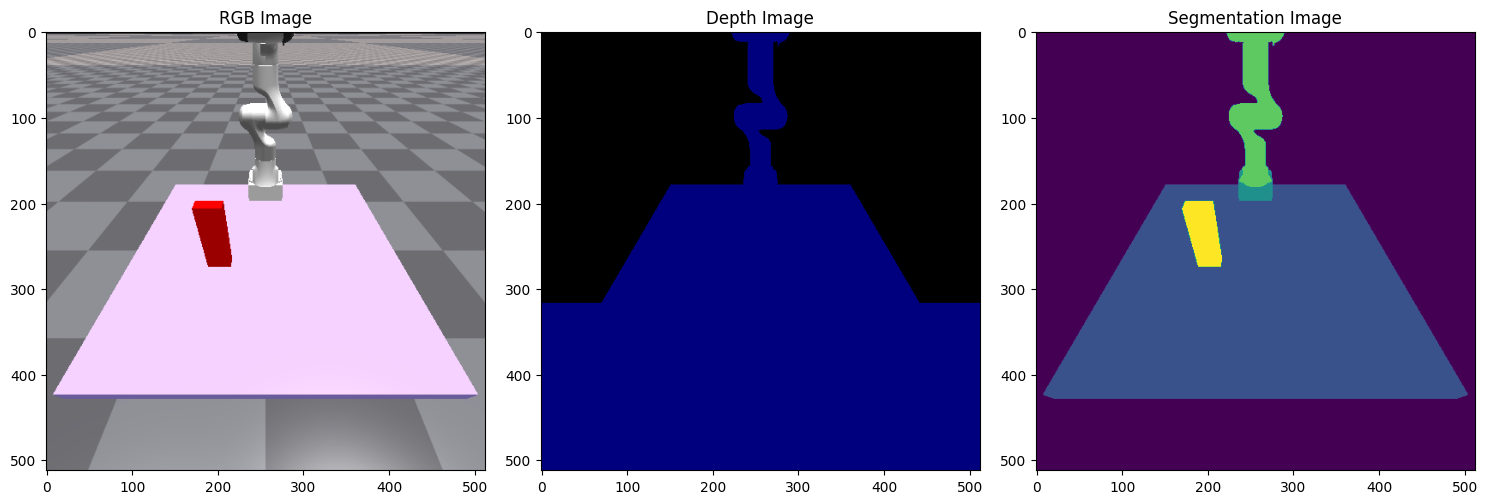

In [3]:
colormap = plt.get_cmap('jet')
depth_colored = colormap(depth / np.max(depth))[:, :, :3]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.title('RGB Image')
plt.subplot(1, 3, 2)
plt.imshow(depth_colored)
plt.title('Depth Image')
plt.subplot(1, 3, 3)
plt.imshow(seg)
plt.title('Segmentation Image')
plt.tight_layout()


In [5]:
depth_object = depth * (seg == 4).astype(np.float32)

In [6]:
depth_object

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

In [7]:
def remove_outliers_from_pcd(pcd_xyz, z_thresh = 2.0):
    assert pcd_xyz.shape[1] == 3, "Input point cloud must be N x 3."

    # Compute mean and std along each axis
    mean = np.mean(pcd_xyz, axis=0)
    std = np.std(pcd_xyz, axis=0)

    # Compute z-scores
    z_scores = np.abs((pcd_xyz - mean) / std)

    # Keep points where all coordinates are within z_thresh
    mask = (z_scores < z_thresh).all(axis=1)
    filtered_pcd = pcd_xyz[mask]

    return filtered_pcd

In [9]:

view_only_object = False

width = 512
height = 512

u = np.arange(0, width)
v = np.arange(0, height)

v2, u2 = np.meshgrid(v, u, indexing='ij')

depth_bar = 2

fu = 2/proj_matrix[0, 0]
fv = 2/proj_matrix[1, 1]

centerU = width/2
centerV = height/2

if view_only_object:
    Z = depth_object.copy()
else:
    Z = depth.copy()

X = -(u2-centerU)/width * Z * fu
Y = (v2-centerV)/height * Z * fv

Z = Z.reshape(-1)
valid = Z > -depth_bar
X = X.reshape(-1)
Y = Y.reshape(-1)

position = np.vstack((X, Y, Z, np.ones(len(X))))[:, valid]
# position = position.permute(1, 0)
position = position.T
position = position@view_inv

points = position[:, 0:3]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(rgb.reshape(-1, 3))

pcd = pcd.voxel_down_sample(voxel_size=0.002)

# cl, ind = pcd.remove_radius_outlier(nb_points=32, radius=0.1)
# pcd = pcd.select_by_index(ind)

coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd, coordinate_frame])

In [22]:
np.unique(np.asarray(pcd.points), axis=0)

array([[ 0.07493577, -0.15171353,  1.08540189],
       [ 0.07499203, -0.15146878,  1.14971617],
       [ 0.07504307, -0.15124648,  1.20813318],
       ...,
       [ 0.12428974, -0.15376743,  1.32533764],
       [ 0.12428974, -0.15086616,  1.32533764],
       [ 0.75      ,  0.        ,  1.75      ]])

In [23]:
np.asarray(pcd.points).shape

(2619, 3)

In [24]:
np.save('./cgn_pytorch/cgn_pytorch/transformed_points.npy', np.asarray(pcd.points))